In [1]:
import os
import json
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from monai import data
from monai import transforms
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    AsDiscrete,
    Activations,
    CropForegroundd, 
    SpatialPad
)
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, ScaleIntensityd, SpatialPadd, Compose
)
from monai.data import Dataset, DataLoader

from monai.inferers import sliding_window_inference
import torch
import torch.nn as nn

In [3]:
roi = (64, 64, 64)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=24,
    use_checkpoint=True,
).to(device)

In [4]:
case_num = "01619"
data_dir = "./TrainingData"
test_files = [
    {
        "image": [
            os.path.join(
                data_dir,
                "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_flair.nii.gz",
            ),
            os.path.join(
                data_dir,
                "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
            ),
            os.path.join(
                data_dir,
                "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1.nii.gz",
            ),
            os.path.join(
                data_dir,
                "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t2.nii.gz",
            ),
        ],
        "label": os.path.join(
            data_dir,
            "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
        ),
    }
]

def calculate_pad_size(original_size):
    return [(((s + 31) // 32) * 32) - s for s in original_size]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        transforms.SpatialPadd(
            keys=["image", "label"],
            spatial_size=(256, 256, 160) 
        ),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

In [5]:
current_dir = os.getcwd()
checkpoint = torch.load(os.path.join(current_dir, "final_model.pt"), weights_only=False)
model.load_state_dict(checkpoint["state_dict"])
model.to(device)
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)

In [6]:
corrected_data = []
for item in test_loader.dataset.data:
    item["image"] = [img_path.replace("TrainingData\\TrainingData", "TrainingData") for img_path in item["image"]]
    corrected_data.append(item)

test_loader.dataset.data = corrected_data

In [7]:
with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4

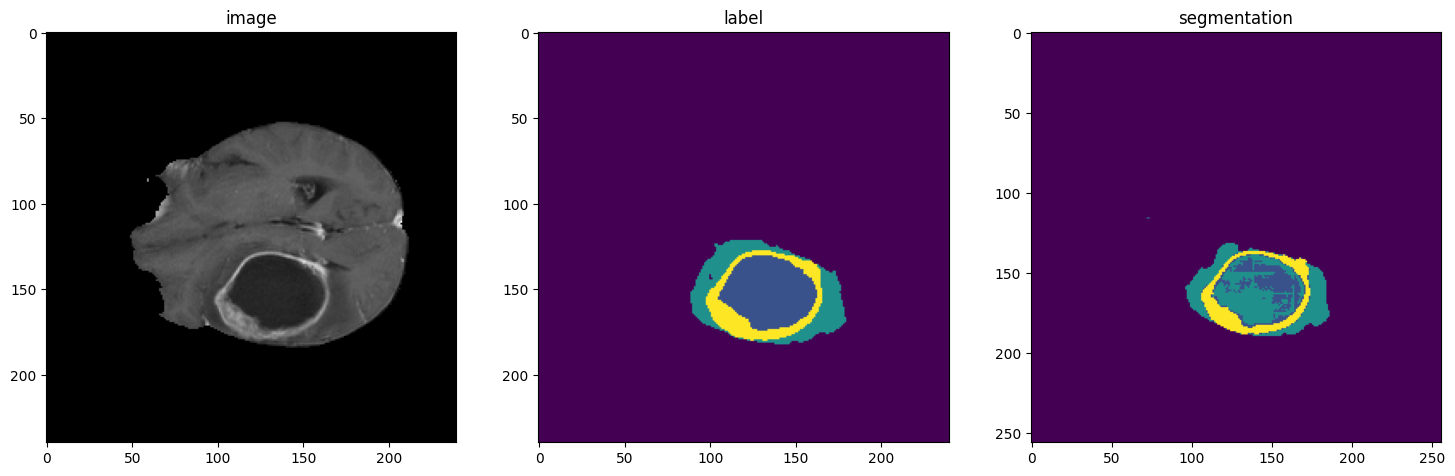

In [8]:
slice_num = 67
img_add = os.path.join(
    data_dir,
    "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
)
label_add = os.path.join(
    data_dir,
    "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()

switch to cpu 

In [9]:
roi = (64, 64, 64)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

model = SwinUNETR(
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=24,
    use_checkpoint=True,
).to(device)

In [10]:
# Define preprocessing transforms
test_transform = Compose([
    LoadImaged(keys=["image"]),  # Load NIfTI images
    EnsureChannelFirstd(keys=["image"]),  # Ensure correct channel order
    ScaleIntensityd(keys=["image"]),  # Normalize intensity
    SpatialPadd(keys=["image"], spatial_size=(256, 256, 160)),  # Pad to required shape
])

# Create dataset & dataloader
test_ds = Dataset(data=test_files, transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

# Load one batch of image data
test_data = next(iter(test_loader))  # Get the first batch
image = test_data["image"].to(device)  # Move to CPU

In [12]:
attentions = []

def hook_fn(module, input, output):
    attentions.append(output)  # Store attention maps

# Register hook to all attention layers
for layer in model.swinViT.layers1[0].blocks:
    layer.attn.register_forward_hook(hook_fn)

# Run inference
with torch.no_grad():
    output = model(image)

# attentions now contain the attention maps


In [13]:
print(attentions[0].shape)

torch.Size([4332, 343, 24])


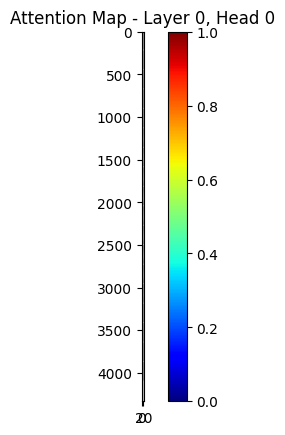

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Select a specific attention layer and head (e.g., first layer, first head)
attn_layer = 0
attn_head = 0

# Extract attention from that layer and head
attn_map = attentions[attn_layer][:, attn_head, :].cpu().numpy()  # Convert to NumPy

# Normalize for visualization
attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

# Plot the attention heatmap
plt.imshow(attn_map, cmap="jet")
plt.colorbar()
plt.title(f"Attention Map - Layer {attn_layer}, Head {attn_head}")
plt.show()


In [23]:
print(f"Last attention shape: {last_attention.shape}")  # Should be (4332, 343, 24)
print(f"Num heads: {num_heads}")  # How many heads are there?
print(f"Patch dimension assumption: {patch_dim}x{patch_dim}")  # Is it correct?

# Select a random attention map to inspect
sample_attn_map = last_attention[:, :, 0]  # Choose the first head
print(f"Sample attention map shape (before processing): {sample_attn_map.shape}")  
# Expected: (4332, 343)


Last attention shape: (4332, 343, 24)
Num heads: 16
Patch dimension assumption: 19x19
Sample attention map shape (before processing): (4332, 343)


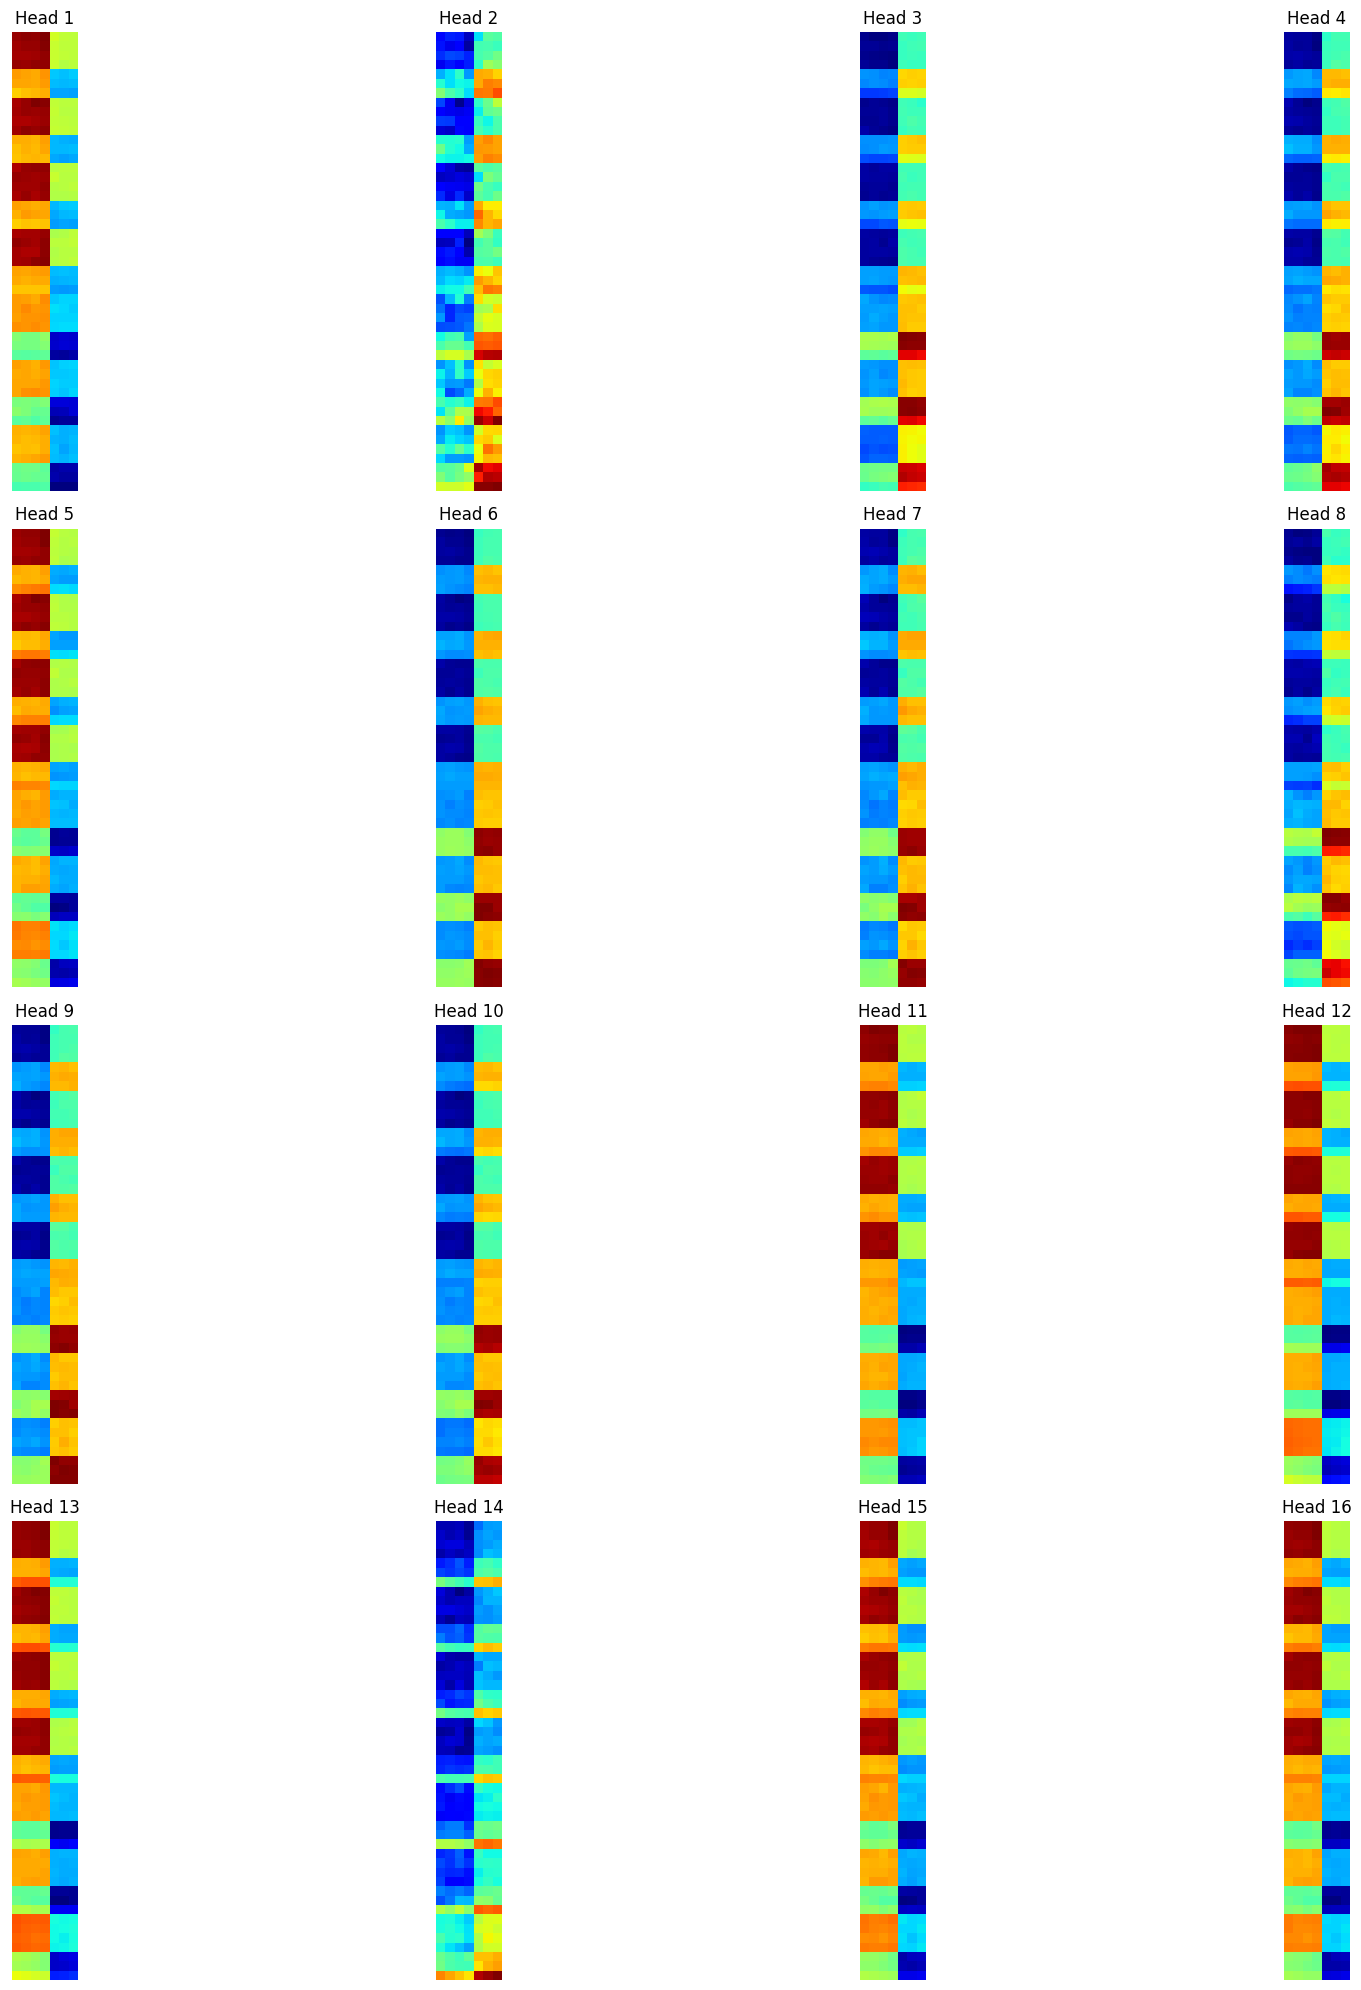

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Convert attention tensors to NumPy
last_attention = attentions[-1].detach().cpu().numpy()  # Shape: (4332, 343, 24)

num_heads = min(16, last_attention.shape[2])  # Ensure max 16 heads

# Define a reasonable reshape size (manually adjusted)
height, width = 49, 7  # Try different values if needed

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i, ax in enumerate(axs.flatten()):
    if i >= num_heads:
        ax.axis("off")
        continue

    # Extract the attention map for the head
    attn_map = last_attention[:, :, i]  # Shape (4332, 343)
    
    # Average over the first dimension (query tokens)
    attn_map = attn_map.mean(axis=0)  # Now shape (343,)

    # Try reshaping into a rectangular grid
    try:
        attn_map = attn_map.reshape(height, width)
    except ValueError:
        print(f"Skipping head {i}: Cannot reshape {attn_map.shape} into ({height},{width})")
        ax.axis("off")
        continue

    ax.imshow(attn_map, cmap="jet")
    ax.set_title(f"Head {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()


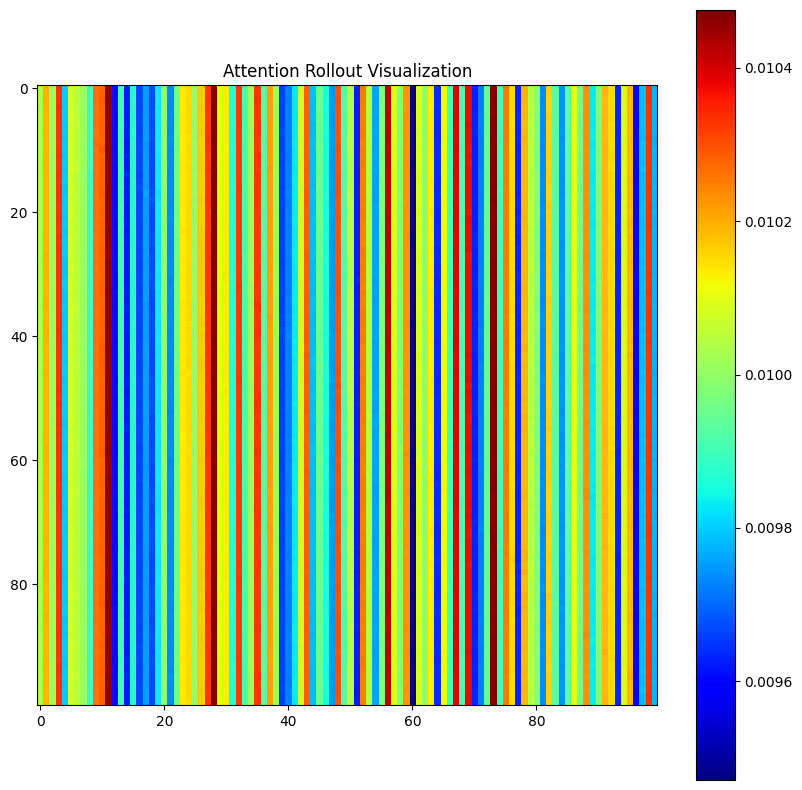

In [30]:
# Simulated attention tensors (assuming 3 layers, 8 heads, 100 tokens)
batch_size, num_layers, num_heads, num_tokens = 1, 3, 8, 100
attentions = [torch.rand(batch_size, num_heads, num_tokens, num_tokens) for _ in range(num_layers)]

# Compute rollout
rollout_attention = attention_rollout(attentions).squeeze(0)  # Shape (num_tokens, num_tokens)

# Convert to NumPy for visualization
rollout_attention_np = rollout_attention.detach().cpu().numpy()

# Plot heatmap
plt.figure(figsize=(10, 10))
plt.imshow(rollout_attention_np, cmap="jet")
plt.colorbar()
plt.title("Attention Rollout Visualization")
plt.show()

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def compute_rollout(attentions):
    """Compute rollout attention maps"""
    result = torch.eye(attentions[0].size(-1)).to(attentions[0].device)
    with torch.no_grad():
        for attention in attentions:
            # Average attention weights across heads
            attention_mean = attention.mean(dim=1)  # Average across heads
            # Ensure proper shape for multiplication
            attention_mean = attention_mean.squeeze()
            # For matrix multiplication, we need to transpose one of the matrices
            result = torch.matmul(attention_mean, result.transpose(-2, -1))
    return result

def create_attention_overlay(image, attention_map, alpha=0.5):
    """
    Create an overlay of the attention map on the original image
    
    Args:
        image: Original image (2D numpy array)
        attention_map: Attention map (2D numpy array)
        alpha: Transparency of the overlay (0-1)
    """
    # Normalize attention map to 0-1
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
    
    # Create a custom colormap (red-yellow)
    colors = [(1, 1, 1, 0), (1, 0, 0, 1)]  # white (transparent) to red
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    
    # Create the overlay
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    # Attention heatmap
    plt.subplot(1, 3, 2)
    plt.title("Attention Heatmap")
    plt.imshow(attention_map, cmap='jet')
    plt.colorbar()
    plt.axis('off')
    
    # Overlay
    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(image, cmap='gray')
    plt.imshow(attention_map, cmap=cmap, alpha=alpha)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()



In [20]:
# When processing attention maps, make sure they have the right shape
attention_maps = []
for attn in attentions:
    # Reshape if necessary
    if len(attn.shape) > 3:
        attn = attn.squeeze(0)  # Remove batch dimension if present
    attention_maps.append(attn)

rollout = compute_rollout(attention_maps)

# Print shapes for debugging
print("Attention map shapes:", [attn.shape for attn in attention_maps])
print("Rollout shape:", rollout.shape)

# Continue with reshaping for visualization
patch_size = 19
img_size = (64,64)
num_patches = (img_size[0] // patch_size, img_size[1] // patch_size)

# Reshape the rollout to match spatial dimensions
attention_reshaped = rollout.reshape(num_patches[0], num_patches[1])
attention_upsampled = torch.nn.functional.interpolate(
    attention_reshaped.unsqueeze(0).unsqueeze(0),
    size=img_size,
    mode='bilinear'
).squeeze().cpu().numpy()
# Get the specific slice you want to visualize
original_slice = img[:, :, slice_num]

# Create the overlay visualization
create_attention_overlay(
    image=original_slice,
    attention_map=attention_upsampled,
    alpha=0.5  # Adjust transparency here
)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4332x24 and 4332x4332)

In [21]:
# Add this debugging code after collecting attentions
print("Original attention shapes:")
for i, attn in enumerate(attentions):
    print(f"Attention {i} shape:", attn.shape)

# Modified compute_rollout function with shape printing
def compute_rollout(attentions):
    """Compute rollout attention maps with debug printing"""
    print("Starting compute_rollout")
    
    # Get initial result shape
    result = torch.eye(attentions[0].size(-1)).to(attentions[0].device)
    print("Initial result shape:", result.shape)
    
    with torch.no_grad():
        for i, attention in enumerate(attentions):
            # Print shapes before processing
            print(f"\nProcessing attention layer {i}")
            print("Current attention shape:", attention.shape)
            print("Current result shape:", result.shape)
            
            # Average attention weights across heads
            attention_mean = attention.mean(dim=1)
            print("After mean attention shape:", attention_mean.shape)
            
            # Try to reshape if needed
            if len(attention_mean.shape) > 2:
                attention_mean = attention_mean.squeeze()
            print("After squeeze attention shape:", attention_mean.shape)
            
            # Print shapes before multiplication
            print("Pre-multiplication shapes:")
            print("attention_mean:", attention_mean.shape)
            print("result:", result.shape)
            
            result = torch.matmul(attention_mean, result)
            print("After multiplication result shape:", result.shape)
    
    return result

# Try to process with the debugging information
attention_maps = []
for attn in attentions:
    if len(attn.shape) > 3:
        attn = attn.squeeze(0)
    attention_maps.append(attn)

rollout = compute_rollout(attention_maps)


Original attention shapes:
Attention 0 shape: torch.Size([4332, 343, 24])
Attention 1 shape: torch.Size([4332, 343, 24])
Attention 2 shape: torch.Size([4332, 343, 24])
Attention 3 shape: torch.Size([4332, 343, 24])
Starting compute_rollout
Initial result shape: torch.Size([24, 24])

Processing attention layer 0
Current attention shape: torch.Size([4332, 343, 24])
Current result shape: torch.Size([24, 24])
After mean attention shape: torch.Size([4332, 24])
After squeeze attention shape: torch.Size([4332, 24])
Pre-multiplication shapes:
attention_mean: torch.Size([4332, 24])
result: torch.Size([24, 24])
After multiplication result shape: torch.Size([4332, 24])

Processing attention layer 1
Current attention shape: torch.Size([4332, 343, 24])
Current result shape: torch.Size([4332, 24])
After mean attention shape: torch.Size([4332, 24])
After squeeze attention shape: torch.Size([4332, 24])
Pre-multiplication shapes:
attention_mean: torch.Size([4332, 24])
result: torch.Size([4332, 24])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4332x24 and 4332x24)